In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans
from qiskit_aer import AerSimulator

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])


C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\tbasi\AppData\Local\Temp\ipykernel_13008\4126752859.py:17: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


# 2 Qubit-channel

Now we will use the algorithm to simulate a 2-qubit quantum channel. In particular, the channel we will simulate is 

$$ \varepsilon(\rho) = (1-p) \rho + \frac{p}{3} (\sigma_3 \otimes I) \rho (\sigma_3 \otimes I) + \frac{p}{3}  (I \otimes \sigma_3) \rho (I \otimes \sigma_3) + \frac{p}{3}  (\sigma_3 \otimes \sigma_3) \rho (\sigma_3 \otimes \sigma_3) $$

To simulate this particular channel, we will need the two principal qubits and two ancilla qubits (to create the probabilities $1-p, p/3, p/3, p/3$). 


In [2]:
"""Function to create the circuit given the value of p.
See code 'Simulation of Pauli Channels' """

def ks_to_circuit(p):
    
    
    #We calculate the angles theta0, theta1, theta2.
    theta0 = np.angle(np.sqrt(1-p)+1j*np.sqrt(p/3))
    theta1 = 2*np.arccos(np.sqrt(1-p+p/3))
    theta2 = np.angle(np.sqrt(1-p)+1j*np.sqrt(p/3))
    
    # We create the circuit with 3 qubits.
    qreg_q = QuantumRegister(4, 'q') 
    circ = QuantumCircuit(qreg_q)
    
    #Add the quantum gates to create the ancilla qubit state.
    circ.ry(theta1,2)
    circ.ry(theta0,3)
    circ.cz(2,3)
    circ.ry(theta2,3)
    
    #Add the controlled gates.
    ciz = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='01')
    czi = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='10')
    
    ciz11 = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    czi11 = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    
    circ.append(ciz, [2,3, 0])
    circ.append(czi, [2,3, 1])

    circ.append(czi11, [2,3, 0])
    circ.append(czi11, [2,3, 1])

    return(circ)



Create many instances of the channel for different values of $p$

In [36]:
ps = np.linspace(0,1,25):

circuits = []
for p in ps:
    circuits.append(ks_to_circuit(p))



### Run Quantum Process tomography

In [38]:
def choi_theoretical(p):
    '''For a value of p describing the Pauli channel, this function
    returns the choi matrix of said channel.
    '''

    k = Kraus([np.sqrt(1-p)*np.kron(I,I),np.sqrt(p/3)*np.kron(Z,I),
                               np.sqrt(p/3)*np.kron(I,Z),np.sqrt(p/3)*np.kron(Z,Z)])
    
    #We convert the Kraus representation to the choi representation of the channel.
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))



In [39]:
from qiskit_experiments.library import ProcessTomography
import qiskit
from qiskit_aer import AerSimulator


In [ ]:
backend = provider.get_backend(computer)

reps = 10

fidelities = []
for i in range(len(ps)):
    p = ps[i]
    circ = circuits[i]
    
    print(i)
    for r in range(reps):
        print(r)
        
    
    
        qpt = ProcessTomography(circ,backend,measurement_indices=[0,1],
                            preparation_indices=[0,1])
        qpt.set_run_options(shots=20000)
    
        qpt_run = qpt.run()
        qptdata = qpt_run.block_for_results()
    
    
        
        choi_simu = qptdata.analysis_results("state").value
        choi_theo = choi_theoretical(p)
    
        dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
        fidelities.append(1-0.5*dis)
        
        with open("Results/2Qubits/fidelity-2qbit-izzizz.csv","a") as f:
            f.write(str(dis)+ ",")
            
    with open("Results/2Qubits/fidelity-2qbit-izzizz.csv","a") as f:
        f.write("\n")
    
    

In [3]:
import csv

res = []
with open("Results/2Qubits/fidelity-2qbit-izzizz.csv","r") as f:
    reader_obj = csv.reader(f)
    print(reader_obj)
    for a in reader_obj:
        c = []
        for i in range(len(a)):
            c.append(float(a[i]))
        res.append(c)
        
res


[[0.908678356488016,
  0.8641934338576971,
  0.9025796799652274,
  0.8785133528179392,
  0.8921454599889455,
  0.8376180984601942,
  0.8883576433295284,
  0.8319105449055767,
  0.8539692544470792,
  0.8789958781709001],
 [0.8345383248615662,
  0.8257239747030007,
  0.8071687915414353,
  0.8059645946738769,
  0.9098410430255026,
  0.8026235862729061,
  0.814681758957651,
  0.8753271114919384,
  0.8296239379847906,
  0.8262291716925976],
 [0.8242178379529063,
  0.7987339334763208,
  0.81032472495756,
  0.8615073165395519,
  0.8300130042123974,
  0.8082367453743935,
  0.8465258263534268,
  0.7970945290394882,
  0.9104984773123814,
  0.8035639283801612],
 [0.7504114149336455,
  0.8279014774275766,
  0.8014658285643239,
  0.7586938235629375,
  0.8882097408725246,
  0.7965407787509281,
  0.8492444886367728,
  0.8458715540663857,
  0.8833634126327135,
  0.7677353078511199],
 [0.73511014085954,
  0.7723745473702003,
  0.764063907406218,
  0.7703381680953806,
  0.7615137253328861,
  0.748471812

Text(0, 0.5, 'f')

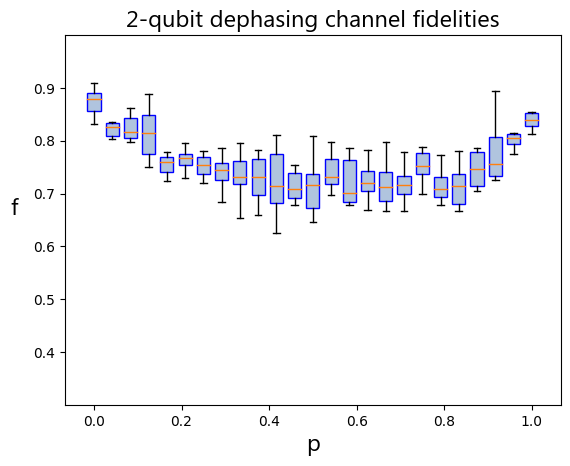

In [24]:
import pandas as pd

plt.boxplot(np.array(res).T,
            positions= np.linspace(0,1,25),
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="lightsteelblue", color="blue"));

plt.ylim([0.3,1])
plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9])
plt.title("2-qubit dephasing channel fidelities",fontname='Microsoft Tai Le',fontsize=17)
plt.xlabel("p",fontsize=17,fontname='Microsoft Tai Le')
plt.ylabel("f",fontsize=17,fontname='Microsoft Tai Le',rotation=0,labelpad=14)

In [7]:
import matplotlib
matplotlib.font_manager.get_font_names()


['Lucida Sans Unicode',
 'Corbel',
 'Juice ITC',
 'DejaVu Sans Mono',
 'cmmi10',
 'Harrington',
 'DejaVu Sans',
 'MingLiU-ExtB',
 'Marlett',
 'Gabriola',
 'Sitka Small',
 'Poor Richard',
 'Snap ITC',
 'cmex10',
 'Parchment',
 'Calibri',
 'Webdings',
 'STIXNonUnicode',
 'Informal Roman',
 'MT Extra',
 'HoloLens MDL2 Assets',
 'Trebuchet MS',
 'TeamViewer15',
 'Segoe UI',
 'Lucida Fax',
 'Nirmala UI',
 'Wingdings 3',
 'Chiller',
 'Microsoft YaHei',
 'Kristen ITC',
 'cmr10',
 'Mistral',
 'Matura MT Script Capitals',
 'Fences',
 'Tahoma',
 'Playbill',
 'SimSun-ExtB',
 'Javanese Text',
 'Garamond',
 'High Tower Text',
 'Monotype Corsiva',
 'French Script MT',
 'Niagara Solid',
 'cmsy10',
 'Magneto',
 'Segoe Print',
 'Bradley Hand ITC',
 'Arial',
 'Berlin Sans FB',
 'Impact',
 'Britannic Bold',
 'Tempus Sans ITC',
 'Microsoft JhengHei',
 'STIXSizeFiveSym',
 'Courier New',
 'Symbol',
 'Franklin Gothic Medium',
 'Myanmar Text',
 'Yu Gothic',
 'Ink Free',
 'Malgun Gothic',
 'Kunstler Script',
 